In [1]:
import networkx as nx

## Graph
NetworkX provides several classes to store different types of graphs, such as directed and undirected graph. It also provides classes to create multigraphs (both directed and undirected).

For more information, please refer to [NetworkX graph types](https://networkx.org/documentation/stable/reference/classes/index.html).

In [9]:
# Create an undirected graph G
G = nx.Graph()
print(G.is_directed())

# Create a directed graph H
H = nx.DiGraph()
print(H.is_directed())

# Add graph level attribute
G.graph["Name"] = "Bar"
print(G.graph)

False
True
{'Name': 'Bar'}


## Node

Nodes (with attributes) can be easily added to NetworkX graphs.

In [16]:
# Add one node with node level attributes
G.add_node(0, feature=5, label=0)

# Get attributes of the node 0
node_0_attr = G.nodes[0]
print("Node 0 has the attributes {}".format(node_0_attr))

Node 0 has the attributes {'feature': 5, 'label': 0}


In [26]:
# Add multiple nodes with attributes
G.add_nodes_from([
  (1, {"feature": 1, "label": 1}),
  (2, {"feature": 2, "label": 2})
]) #(node, attrdict)

# Loop through all the nodes
# Set data=True will return node attributes
for node in G.nodes(data=True):
  print(node)

# Get number of nodes
num_nodes = G.number_of_nodes()
print("G has {} nodes".format(num_nodes))

(0, {'feature': 5, 'label': 0})
(1, {'feature': 1, 'label': 1})
(2, {'feature': 2, 'label': 2})
G has 3 nodes


## Edge

Similar to nodes, edges (with attributes) can also be easily added to NetworkX graphs.

In [27]:
# Add one edge with edge weight 0.5
G.add_edge(0, 1, weight=0.5)

# Get attributes of the edge (0, 1)
edge_0_1_attr = G.edges[(0, 1)]
print("Edge (0, 1) has the attributes {}".format(edge_0_1_attr))

Edge (0, 1) has the attributes {'weight': 0.5}


In [30]:
G.edges[(0,1)]

{'weight': 0.5}

In [31]:
# Add multiple edges with edge weights
G.add_edges_from([
  (1, 2, {"weight": 0.3}),
  (2, 0, {"weight": 0.1})
])

# Loop through all the edges
# Here there is no data=True, so only the edge will be returned
for edge in G.edges(data=True):
  print(edge)

# Get number of edges
num_edges = G.number_of_edges()
print("G has {} edges".format(num_edges))

(0, 1, {'weight': 0.5})
(0, 2, {'weight': 0.1})
(1, 2, {'weight': 0.3})
G has 3 edges


## Visualization

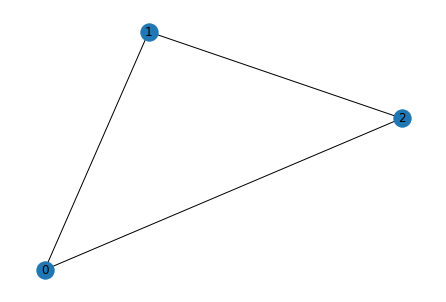

In [38]:
# Draw the graph
%matplotlib inline
nx.draw(G, with_labels = True)

## Node Degree and Neighbor

In [42]:
node_id = 1

# Degree of node 1
print("Node {} has degree {}".format(node_id, G.degree[node_id]))

# Get neighbor of node 1
for neighbor in G.neighbors(node_id):
  print("Node {} has neighbor {}".format(node_id, neighbor))

Node 1 has degree 2
Node 1 has neighbor 0
Node 1 has neighbor 2


## Other Functionalities

NetworkX also provides plenty of useful methods to study graphs.

Here is an example to get [PageRank](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_analysis.pagerank_alg.pagerank.html#networkx.algorithms.link_analysis.pagerank_alg.pagerank) of nodes (see [last year's slides on PageRank](http://snap.stanford.edu/class/cs224w-2020/slides/04-pagerank.pdf) for more information!).

{0: 0.17857162031103999,
 1: 0.32142837968896,
 2: 0.32142837968896,
 3: 0.17857162031103999}

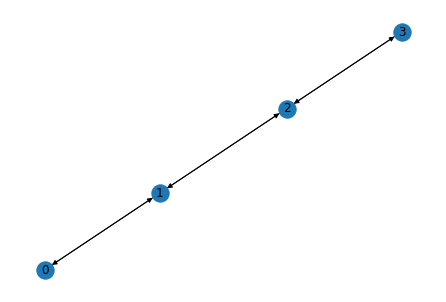

In [87]:
num_nodes = 4
# Create a new path like graph and change it to a directed graph
G = nx.DiGraph(nx.path_graph(num_nodes))
nx.draw(G, with_labels = True)

# Get the PageRank
pr = nx.pagerank(G, alpha=0.8)
pr

## Documentation
You can explore more NetworkX functions through its [documentation](https://networkx.org/documentation/stable/).

# PyTorch Geometric Tutorial

PyTorch Geometric (PyG) is an extension library for PyTorch. It provides useful primitives to develop Graph Deep Learning models, including various graph neural network layers and a large number of benchmark datasets.

Don't worry if you don't understand some concepts such as `GCNConv` -- we will cover all of them in the future lectures :)

This tutorial is adapted from https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing#scrollTo=ci-LpZWhRJoI by [Matthias Fey](https://rusty1s.github.io/#/)


In [89]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.9.0


In [90]:
# Helper function for visualization.
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

# Visualization function for NX graph or PyTorch tensor
def visualize(h, color, epoch=None, loss=None, accuracy=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None and accuracy['train'] is not None and accuracy['val'] is not None:
            plt.xlabel((f'Epoch: {epoch}, Loss: {loss.item():.4f} \n'
                       f'Training Accuracy: {accuracy["train"]*100:.2f}% \n'
                       f' Validation Accuracy: {accuracy["val"]*100:.2f}%'),
                       fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

## Introduction

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.

Following [Kipf et al. (2017)](https://arxiv.org/abs/1609.02907), let's dive into the world of GNNs by looking at a simple graph-structured example, the well-known [**Zachary's karate club network**](https://en.wikipedia.org/wiki/Zachary%27s_karate_club). This graph describes a social network of 34 members of a karate club and documents links between members who interacted outside the club. Here, we are interested in detecting communities that arise from the member's interaction.

In [91]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


After initializing the [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) dataset, we first can inspect some of its properties.
For example, we can see that this dataset holds exactly **one graph**, and that each node in this dataset is assigned a **34-dimensional feature vector** (which uniquely describes the members of the karate club).
Furthermore, the graph holds exactly **4 classes**, which represent the community each node belongs to.

Let's now look at the underlying graph in more detail:

In [ ]:
data.

In [95]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {(2*data.num_edges) / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 9.18
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [98]:
data.edge_index.T

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 